In [95]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import patches
import sqlite3 as db
import os
import blender_config as cng
from typing import Iterable, Callable, Sequence, List, Dict, Optional
from skimage import io

In [49]:
for var, val in cng.__dict__.items():
    if (val is not None) and not var.startswith('_'):
        print(f"{var} = {val}") 

pi = 3.141592653589793
SRC_CLTN = Fishes
TRGT_CLTN = Copies
REF_CLTN = Reference
SPAWNBOX_OBJ = spawnbox
CAMERA_OBJ = Camera
ROT_MUS = [1.5707963267948966, 0, 3.141592653589793]
ROT_STDS = [0.5, 1, 1]
DEFAULT_BBOX_MODE = xyz
COMMIT_INTERVAL = 32
GENERATED_DATA_DIR = generated_data
IMAGE_DIR = images
IMAGE_NAME = img
DEFAULT_FILEFORMAT = PNG
DEFAULT_FILEFORMAT_EXTENSION = .png
BBOX_DB_FILE = bboxes.db
BBOX_DB_IMGRNR = imgnr
BBOX_DB_CLASS = class_
BBOX_MODE_CPS = cps
BBOX_MODE_XYZ = xyz
BBOX_MODE_STD = std
BBOX_DB_TABLE_XYZ = bboxes_xyz
BBOX_DB_TABLE_CPS = bboxes_cps
BBOX_DB_TABLE_STD = bboxes_std
FILE_SUFFIX_LEFT = _L
FILE_SUFFIX_RIGHT = _R
ARGS_DEFAULT_ENGINE = CYCLES
ARGS_DEFAULT_DEVICE = CUDA
ARGS_DEFAULT_RENDER_SAMPLES = 96
ARGS_DEFAULT_BBOX_MODE = all
ARGS_DEFAULT_VIEW_MODE = stereo
HIGHLIGHT_WIDTH = 70
BOXED_SYMBOL_TOP = =
BOXED_SYMBOL_BOTTOM = =
BOXED_STR_SIDE = ||
SECTION_SYMBOL = -
SECTION_START_STR = 
SECTION_END_STR = 



In [61]:
def show_imgs(imgs: Sequence[np.ndarray], titles: Optional[Sequence[str]]=None, 
              n_cols: int=4, colsize: int=2, rowsize: int=2, clip: bool=False) -> None:
    '''
    Visualize iterable of np.ndarray objects using plt.imshow
    
    imgs: iterable of images. If you want to plot one image you gotta do show_imgs([image]).
    
    titles: optional, list of titles
    
    colsize: size multiplier in figsize=(colsize*n_cols,...)
    rowsize: size multiplier in figsize=(...,rowsize*n_rows)
    '''
    if titles is None:
        titles = []
    
    n = len(imgs)
    n_cols=n if n < n_cols else n_cols
    n_rows=int(np.ceil(n/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(colsize*n_cols,rowsize*n_rows))
    axes = np.ravel(axes)
    for ax, img in zip(axes, imgs):
        if clip: img = img.clip(0,1)
        ax.imshow(img)
    
    # Set titles
    [ax.set_title(title) for ax, title in zip(axes, titles)]
        
    # Turn off spines on empty plots
    for ax in axes.ravel()[-(n_cols*n_rows-n):]:
        ax.axis('off')
    
    plt.setp(axes.ravel(), xticks=[], yticks=[])
    
    fig.tight_layout()
    plt.show()

In [135]:
class BlenderData:
    def __init__(self, data_dir: str):
        self.data_dir = data_dir
        self.sqlite_file = os.path.join(data_dir, cng.BBOX_DB_FILE)
        self.image_dir = os.path.join(data_dir, cng.IMAGE_DIR)
        self.con = db.connect(f'file:{self.sqlite_file}?mode=ro', uri=True)
        
    def query(self, q: str) -> pd.DataFrame:
        return pd.read_sql_query(q, self.con)
    
    def get_image(self, imgnr: int, suffixes: Sequence[str]):
#         return io.imread(os.path.join(self.image_dir, f'{cng.IMAGE_NAME}'))
        imgs = []
        for suffix in suffixes:
            try:
                imgs.append(io.imread(os.path.join(
                    self.image_dir, f'{cng.IMAGE_NAME}{imgnr}{suffix}{cng.DEFAULT_FILEFORMAT_EXTENSION}')
                ))
            except FileNotFoundError as e:
                imgs.append(None)
        return imgs
    
    def plot_std_bboxes(self, imgnr: int, suffix: str):
        fig, ax = plt.subplots(figsize=(7,5))
        img = self.get_image(imgnr, [suffix])[0]
        img_h, img_w = img.shape[:-1]
        bboxes = self.query(
            f'SELECT class_, x, y, w, h FROM bboxes_std WHERE imgnr == {imgnr}'
        ).values
        
        ax.imshow(img)
        
        for class_, x, y, w, h in bboxes:
            topLeftCorner = (x*img_h, y*img_w)
            ax.add_patch(patches.Rectangle(topLeftCorner, w*img_w, h*img_h, facecolor='none',edgecolor='red'))
            ax.text(x=topLeftCorner[0], y=topLeftCorner[1], s=class_)

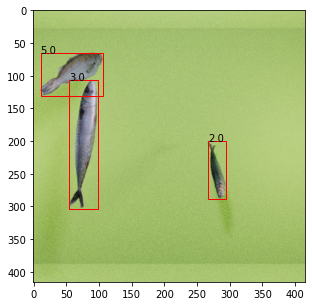

In [136]:
data = BlenderData(cng.GENERATED_DATA_DIR)
data.plot_std_bboxes(8, '')

In [99]:
data.query('SELECT class_, x, y, w, h FROM bboxes_std WHERE imgnr == 8')

,class_,x,y,w,h
0,3,0.132,0.255,0.104,0.475
1,2,0.641,0.482,0.068,0.212
2,5,0.026,0.157,0.230,0.158
